# Домашнее задание 3 [10 баллов] 
# До 16.05.18 23:59

Задание выполняется в группе (1-4 человека). В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.

Не все части обязательны для выполнения, однако вы можете быть дополнительно оштрафованы за небрежное за выполнение одной или двух частей вместо четырех.

При возниконовении проблем с выполнением задания обращайтесь с вопросами к преподавателю. Поэтому настоятельно рекомендуется выполнять задание заранее, оставив запас времени на всевозможные технические проблемы. Если вы начали читать условие в последний вечер и не успели из-за проблем с установкой какой-либо библиотеки — это ваши проблемы.


Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание **минимума** необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* **Внятные выводы** – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Небрежное его оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в тексте в явном виде.

Сдача отчетов осуществляется через систему AnyTask.



# Классификация текстов с активным обучением


Зададимся простой задачей классификации текстов: например, классификацией отзывов на банки по тональности. Эта задача решается с достаточно высокими показателями качества с использованием стандартных алгоритмов классификации, например, сверточных нейронных сетей: корпус состоит из достаточного количества документов, чтобы сверточная сеть хорошо обучилась. Однако возникает естественный вопрос: действительно ли все документы нужны для того, чтобы достичь таких высоких показателей качества (или сопоставимых с ними). Парадигма активного обучения поможет вам ответить на этот вопрос.

## Часть 1. Предобработка данных [2 балла]

Коллекция отзывов хранится в файле banki_responses (https://www.dropbox.com/s/ol3ux3ibr6rd5ke/banki_responses.json.bz2?dl=0). Одна строчка в этом файле соответствует одному json-словарю. Из этого словаря вам понадобятся два значения по ключам text и rating -- текст отзыва и его оценка по шкале от 1 до 5.   

Считайте файл. Посчитайте, каких отзывов больше: положительных или отрицательных? 

Проведите предварительную обработку данных: удалите слишком короткие и слишком длинные тексты (пороги на длину определите самостоятельно). 

Разбейте данные на обучающее ($train$) и тестовое ($test$) множество случайным образом в отношеннии 3:1 (или любом другом отношении, которое покажется вам разумным). 

Задача классификации сформулирована так: по каждому отзыву определить его оценку (т.е. классификация на 5 классов). Признаками для классификации выступают слова.

Сперва считаем данные

In [ ]:
import json

responses = []
for line in open('banki_responses.json', 'r'):
    responses.append(json.loads(line))

In [2]:
key_text = 'text'
key_grade = 'rating_grade'

In [3]:
from collections import Counter

grade_distribution = Counter(map(lambda record: record[key_grade], responses))

Как видим негативные отзывы превалируют над положительными:

In [4]:
grade_distribution

Counter({1: 72307, 2: 19928, 3: 11702, 4: 5537, 5: 26715, None: 64841})

In [5]:
responses = list(filter(lambda x: x[key_grade] != None, responses))

In [21]:
import re

def calc_word_count(string):
    return len(re.findall("\w+", string))

Попробуем убрать stop-слова (предлоги, союзы, и т.д.), т.к. они практически не несут смысловой нагрузки

In [7]:
from stop_words import get_stop_words
stop_words = get_stop_words('russian')

Также загрузим ембеддинги из 2-ого задания и оставим только те слова, которые имеют соответствующий вектор ембеддингах

In [8]:
import numpy as np

embeddings = {}
with open('/Users/user/MIPT-text-analysis/wiki.ru.vec', 'r') as fin:
    word_count, embedding_size = [int(number) for number in fin.readline().split(' ')]
    for i in range(word_count):
        data = fin.readline().split(' ')[:-1]
        word = data[0]
        embedding = np.array([float(number) for number in data[1:]])
        embeddings[word.lower()] = embedding

In [9]:
def clean_response(response):
    good_words = []
    for word in re.findall("\w+", response):
        word = word.lower()
        if word in embeddings and word not in stop_words:
            good_words.append(word)
    return ' '.join(good_words)

Оставим только текст отзыва и оценку

In [10]:
raw_data = [(record[key_text], record[key_grade]) for record in responses]

Собственно фильтрация содержимого отзывов

In [13]:
data = list(map(lambda response: (clean_response(response[0]), response[1]), raw_data))

Теперь построим гистограмму числа слов в отзыве

In [22]:
responses_lengths = list(map(lambda record: calc_word_count(record[0]), data))
responses_lengths_distribution = Counter(responses_lengths)

In [23]:
import matplotlib.pyplot as plt

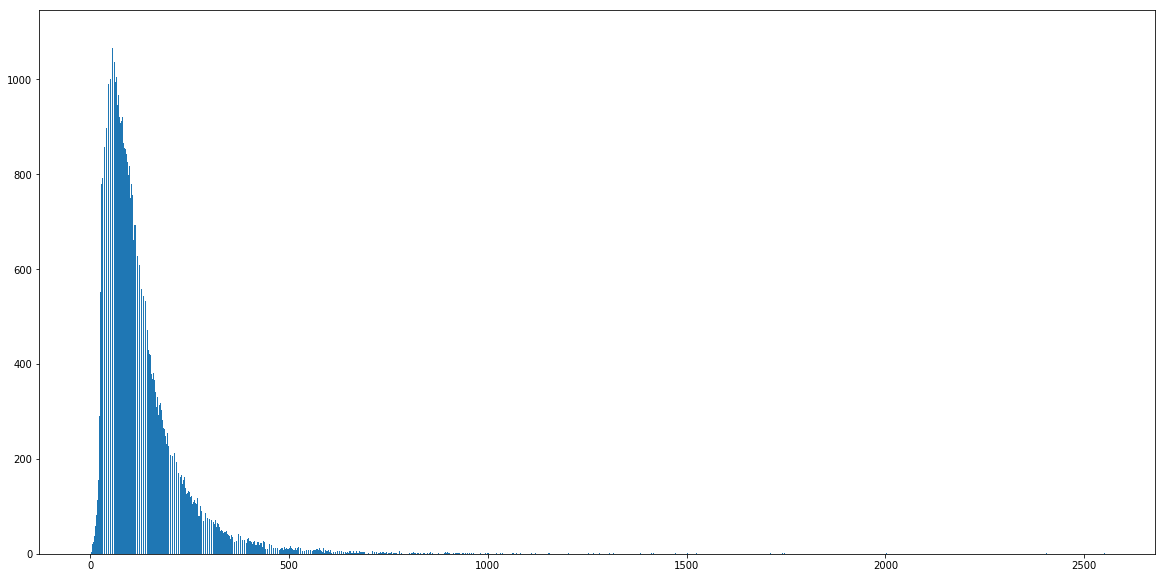

In [24]:
%matplotlib inline  

zipped_length_distribution = list(zip(*responses_lengths_distribution.items()))

plt.figure(figsize=(20,10))
plt.bar(zipped_length_distribution[0], zipped_length_distribution[1])
plt.show()

Попробуем понять, какой диапазон числа слов нужно взять

In [25]:
def count_part_in_range(left, right):
    return len(list(x for x in responses_lengths if x >= left and x <= right)) / len(responses_lengths)

In [26]:
left_length_border = 40
right_length_border = 200

In [27]:
count_part_in_range(left_length_border, right_length_border)

0.7490619653569671

Предварительно возьмем такой диапазон числа слов. Мы покрываем почти 75% выборки.

In [31]:
filtered_data = [resp for resp in data if calc_word_count(resp[0]) >= left_length_border and calc_word_count(resp[0]) <= right_length_border]

In [32]:
from random import shuffle

shuffle(filtered_data)

raw_x, raw_y = list(zip(*filtered_data))

In [33]:
train_part_coeff = 0.8
train_part_size = int(len(raw_x) * train_part_coeff)

In [34]:
train_part_size

81611

## Часть 2. Baseline [4 балла]

Получите baseline классификации: в идеале, используйте сверточную нейронную сеть (слой эмбеддингов + свертка + субдескритизация). Число и размерность фильтров определите самостоятельно, так же как и использование регуляризаторов (dropout / batch norm) и их параметров. Так же самостоятельно (но обосновано) решите, использовать ли вам предобученные эмбеддинги или нет и проводить ли вам лемматизацию или нет. 

Обучите сеть на обучающем множестве и протестируйте на тестовом. Зафиксируйте baseline.

Если совсем трудно или вычисления занимают слишком много времени, используйте любой другой известный и симпатичный вам алгоритм классификации. 

Сконфигурируем нейронную есть

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


Воспользуемся инструментами из библиотеки keras для создания индекса слов и создания датасета. Для отзывов длины меньше right_length_border будет использоваться padding

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_x)
sequences = tokenizer.texts_to_sequences(raw_x)

In [38]:
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=right_length_border)
labels = to_categorical(np.asarray(raw_y) - 1)

Разобъем выборку на train и test в соотношении 4:1 (задано выше)

In [39]:
x_train = data[:train_part_size]
y_train = labels[:train_part_size]

x_test = data[train_part_size:]
y_test = labels[train_part_size:]

Построим embedding-матрицу для инициализации embedding-слоя

In [40]:
EMBEDDING_DIM = len(embeddings['мама'])

In [41]:
embeddings_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM), dtype=np.float32)

for word, word_id in word_index.items():
    if word in embeddings:
        embeddings_matrix[word_id] = embeddings[word]

Зададим архитектуру сети

In [42]:
from keras.layers import Activation, Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D, BatchNormalization
from keras import Model

In [43]:
sequence_input = Input(shape=(right_length_border,), dtype='int32')
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=right_length_border,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)

In [45]:
net = Conv1D(128, 5)(embedded_sequences)
net = BatchNormalization()(net)
net = Activation('relu')(net)

net = MaxPooling1D(5)(net)

net = Conv1D(128, 5)(net)
net = BatchNormalization()(net)
net = Activation('relu')(net)

net = MaxPooling1D(5)(net)
net = Flatten()(net)

net = Dense(128)(net)
net = BatchNormalization()(net)
net = Activation('relu')(net)

preds = Dense(5, activation='softmax')(net)

Будем использовать оптимизатор

In [46]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [47]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=1, batch_size=256)

Train on 81611 samples, validate on 20403 samples
Epoch 1/1
81611/81611 [==============================] - 618s 8ms/step - loss: 0.9354 - acc: 0.6673 - val_loss: 0.9671 - val_acc: 0.6724


In [ ]:
model.save_weights('test.model')

In [ ]:
import keras
from keras import models
model = keras.models.load_model('baseline_BN3.model')

## Часть 3. Baseline [4 балла] Активное обучение

Подход активного обучения основан на следующей идее: вместо всего обучающего множества мы используем его маленькие фрагменты, в которых модель неуверена для обучения. Таким образом, модель обучается исключительно по **трудным** объектам, число которых существенно меньше, чем общее число объектов.

Обучение модели начинается с обучения по $N$ случайно выбранным примерам, где $N$ – небольшое число (100, 200 и т.д.). Затем модель тестируется на $|train| - N$ объектах, после чего из  $|train| - N$ объектов выбираются снова $N$  объектов, в которых модель не уверена. Эти объекты используются для дообучения модели. Процесс выбора $N$ трудных объектов и дообучения на них повторяется некоторое количество раз (100, 200 и т.д. раз). На каждом шаге активного обучения модель можно протестировать на тестовом множестве, чтобы сравнить ее качества с baseline.

Как выбирать трудные объекты:
1. Выход нейронной сети - оценки 5 вероятностей принадлежности объекта одному из классов. Предсказанный класс – это тот класс, вероятность которого максимальна. Отсортируем объекты по убыванию вероятности предсказанного класса ($\min \max p_i$) и выберем $N$ первых объектов;
2. Используем энтропию: чем больше энтропия предсказания, тем ближе распределение вероятностей предсказания к равномерному распределению, тем труднее объект. 